# Installation

In [ ]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 4.3 MB/s eta 0:00:00


# Importation des bibliothéques

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from collections import Counter

import torch
from transformers import FlaubertForSequenceClassification, FlaubertTokenizer , AdamW, get_linear_schedule_with_warmup

from torch.utils.data import TensorDataset, DataLoader,  RandomSampler, SequentialSampler
import random
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from datetime import datetime, timedelta
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Chargement des données

In [ ]:
df = pd.read_csv('all_data_V1_cleaned.csv')
df

,entreprise,type_contrat,date_publication,date_mise_a_jour,salaire,prise_de_poste,experience,metier,statut_du_poste,zone_de_deplacement,...,profil_recherche,langues,savoir_etre,savoir_faire,descriptif_entreprise,nombre_posts,duree,ville,code_postal,departement
0,MICHAEL PAGE INTERNATIONAL FRANCE,CDI,2024-02-29,2024-02-29,40.0,Dès que possible,0,Développeur,Cadre du secteur privé,Pas de déplacement,...,"De formation supérieure en informatique, vous ...",Aucune langue attendue,"['Autonomie', ""Capacité d'analyse"", 'Capacité ...","['Application Web', 'Développement web', 'Info...",Notre client est un éditeur de logiciels dans ...,1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
1,Charlotte Drahy sas,CDI,2024-01-17,2024-03-15,40.0,Dès que possible,5,Développeur,Cadre du secteur privé,Nationale,...,Les compétences requises sont :\nProgrammation...,"Anglais, Français","[""Esprit d'équipe"", 'Motivation', 'Rigueur']","['Analyse des besoins', 'Analyse fonctionnelle...","""Charlotte Drahy sas"" est une société de conse...",1,NaN,Aubagne,13,Bouches-du-Rhône
2,LOEMA,CDI,2024-02-22,2024-02-22,47.5,Dès que possible,4,Développeur,Cadre du secteur privé,Pas de déplacement,...,Vous avez une expérience en : \n- Programma...,Aucune langue attendue,"['Curiosité', 'Goût du challenge']","['ASP.NET', 'Bootstrap Protocol', 'C sharp', '...",Situé au cœur même de la ville de Marseille no...,1,NaN,Marseille,13,Bouches-du-Rhône
3,CELAD,CDI,2024-02-29,2024-02-29,36.0,Dès que possible,1,Développeur,Cadre du secteur privé,Pas de déplacement,...,"Idéalement ingénieur de formation, vous justif...",Aucune langue attendue,"['Autonomie', 'Force de proposition', 'Qualité...","['Framework', 'JavaScript', 'ReactJS', 'TypeSc...","Issu du monde bancaire, #CELAD a été créée en ...",1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
4,EASY PARTNER,CDI,2024-03-01,2024-03-01,40.0,Dès que possible,3,Développeur,Cadre du secteur privé,Pas de déplacement,...,Profil recherché\nNous recherchons un profil a...,Aucune langue attendue,"['Ambition', 'Autonomie', 'Bienveillance', 'Ca...","['Nuxt', 'Vue.js', 'Développement web', 'React...",Easy Partner est un Cabinet de recrutement dig...,1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,Seyos,CDI,2024-03-15,2024-03-15,52.5,Dès que possible,5,Business developer,Cadre du secteur privé,Pas de déplacement,...,Profil recherché :\nVous avez une expérience s...,Aucune langue attendue,"['Force de proposition', 'Proactivité']","['Manutention', 'Automatisme', 'Cahier des cha...",Seyos est un cabinet de recrutement spécialisé...,1,NaN,Tonneins,47,Lot-et-Garonne
8038,LES COLETTES,CDI,2024-03-12,2024-03-12,NaN,Dès que possible,2,Ingénieur test et recettes,Cadre du secteur privé,Pas de déplacement,...,"Issu(e) d'une formation en informatique, idéal...",Aucune langue attendue,"[""Esprit d'équipe""]","['Cloud', 'Jira', 'SAAS', 'Algorithme', 'Autom...",Editeur de logiciels français multi-sectoriel ...,1,NaN,Villeneuve-sur-Lot,47,Lot-et-Garonne
8039,Armée de l'Air et de l'Espace,CDD,2024-02-21,2024-02-21,34.0,Dès que possible,0,Consultant en cybersécurité,Cadre du secteur public / Armées,Nationale,...,"Jeune diplômé, avec ou sans expérience profess...",Anglais,"[""Capacité d'adaptation"", 'Capacité de communi...","['Analyse des risques', 'Gestion de projet', '...",L’armée de l’Air et de l’Espace a pour mission...,1,de 5 mois,Saint-Dizier,52,Haute-Marne
8040,Armée de l'Air et de l'Espace,CDD,2024-02-16,2024-02-16,22.5,Dès que possible,0,Responsable sécurité informatique,Cadre du secteur public / Armées,Nationale,...,"Diplômé, avec ou sans expérience professionnel...",Anglais,"[""Capacité d'adaptation"", 'Capacité de communi...","['Analyse des risques', 'Gestion de projet', '...",L’armée de l’Air et de l’Espace a pour mission...,1,de 5 mois,Saint-Dizier,52,Haute-Marne


# Prétraitement

## Prétraitement des données

In [ ]:
def remove_ponctuation(sentence):
    punc = string.punctuation
    punc += '\n\r\t'
    sentence = sentence.translate(str.maketrans(punc, ' ' * len(punc)))
    sentence = re.sub('( )+', ' ', sentence)  # Supprimer les espaces en trop
    return sentence

def remove_numbers(sentence):
    return re.sub('[0-9]+', '', sentence)

def remove_stopwords_Fr(sentence):
    stop_words = set(stopwords.words('french'))
    additional_stop_words = {'informatique', 'gestion', 'management', 'projet', 'équipe', 'mission', 'client'}
    stop_words.update(additional_stop_words)
    tokens = nltk.word_tokenize(sentence)
    filtered_sentence = [word.lower()  for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_sentence)

In [ ]:
df["preprocessed_description"] = df["descriptif_poste"].apply(lambda x: remove_stopwords_Fr(remove_numbers(remove_ponctuation(x))))
df[["preprocessed_description"]]

,preprocessed_description
0,tant développeur web fonctions conception déve...
1,motivé rigoureux concevez développez applicati...
2,recherche développeur web full stack net core ...
3,poursuivons développement sud recrutons e ingé...
4,contexte poste entreprise ancrée secteur touri...
...,...
8037,description représentons groupe accès industri...
8038,entouré e passionné e enjeux poste testeur aut...
8039,faire appliquer politique sécurité réglementat...
8040,faire appliquer politique sécurité réglementat...


## Prétraitement des labels

In [ ]:
def map_metier_to_label(metier):
    data = ['Administrateur data center', 'Administrateur de bases de données', 'Architecte Big Data', 'Business analyst', 'Chief Data Officer', 'Data analyst', 'Data engineer', 'Data scientist', 'Délégué à la protection']
    reseaux = ['Administrateur réseaux', 'Administrateur système', 'Architecte infrastructures', 'Architecte réseaux', 'Architecte système', 'Ingénieur de maintenance informatique', 'Ingénieur de production informatique', 'Ingénieur informatique industrielle', 'Ingénieur réseaux', 'Ingénieur système', 'Ingénieur télécoms']
    dev = ['Architecte développement', 'Business developer', 'Consultant technique progiciel', 'Développeur' ,'Ingénieur R&D', 'Ingénieur en études et développement informatiques', 'Ingénieur informatique embarquée', 'Ingénieur intégration progiciel', 'Ingénieur test et recettes', 'Ingénieur test et essai']
    chef_projet = ['Chef de projet Agile', 'Chef de projet R&D', 'Chef de projet digital', 'Chef de projet fonctionnel web', 'Chef de projet informatique', 'Chef de projet informatique décisionnelle', 'Directeur de projets informatiques', 'Project management officer', 'Responsable informatique']
    cybersecu = ['Consultant en cybersécurité', 'Ingénieur sécurité informatique', 'Responsable sécurité informatique']

    if metier in data:
        return 0
    elif metier in reseaux:
        return 1
    elif metier in dev:
        return 2
    elif metier in chef_projet:
        return 3
    elif metier in cybersecu:
        return 4
    else:
        return 5

In [ ]:
df['label'] = df['metier'].apply(map_metier_to_label)

In [ ]:
filtred_df = df[["preprocessed_description" , "label"]]
filtred_df

,preprocessed_description,label
0,tant développeur web fonctions conception déve...,2
1,motivé rigoureux concevez développez applicati...,2
2,recherche développeur web full stack net core ...,2
3,poursuivons développement sud recrutons e ingé...,2
4,contexte poste entreprise ancrée secteur touri...,2
...,...,...
8037,description représentons groupe accès industri...,2
8038,entouré e passionné e enjeux poste testeur aut...,2
8039,faire appliquer politique sécurité réglementat...,4
8040,faire appliquer politique sécurité réglementat...,4


### Distribution plot

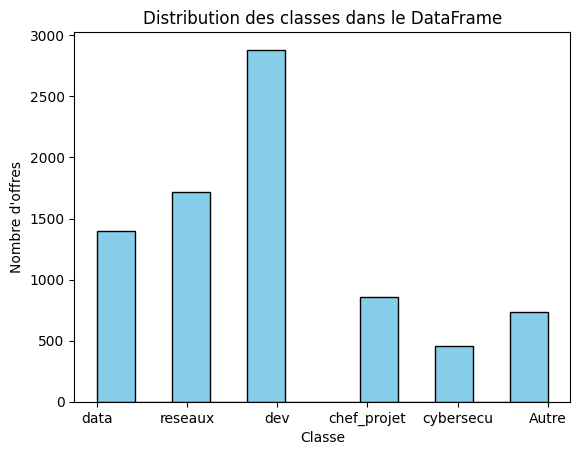

In [ ]:
plt.hist(filtred_df['label'], bins=12, color='skyblue', edgecolor='black')
plt.title('Distribution des classes dans le DataFrame')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'offres')
plt.xticks([0, 1 , 2 , 3 , 4 , 5], labels= ["data" , "reseaux" , "dev" , "chef_projet" , "cybersecu" , "Autre"])  # Définir les étiquettes de l'axe x
plt.show()

D'aprés ce plot, on remarque que nos classes sont déséquilibrées

## Diviser les données en Train/Test

In [ ]:
random_state=42

In [ ]:
train_ind , test_ind = train_test_split(filtred_df.index , test_size=0.2, shuffle = True , random_state=random_state)

train_df = filtred_df.loc[train_ind , :]
test_df = filtred_df.loc[test_ind , :]

print("All dataset shape : ", filtred_df.shape)
print("Train shape : ", train_df.shape)
print("Test shape : ",test_df.shape)

All dataset shape :  (8042, 2)
Train shape :  (6433, 2)
Test shape :  (1609, 2)


### Equilibrer Training set

In [ ]:
min_train_count = train_df["label"].value_counts().min()
min_train_count

370

In [ ]:
train_df = pd.concat([group.sample(min_train_count) for name , group in train_df.groupby("label")])

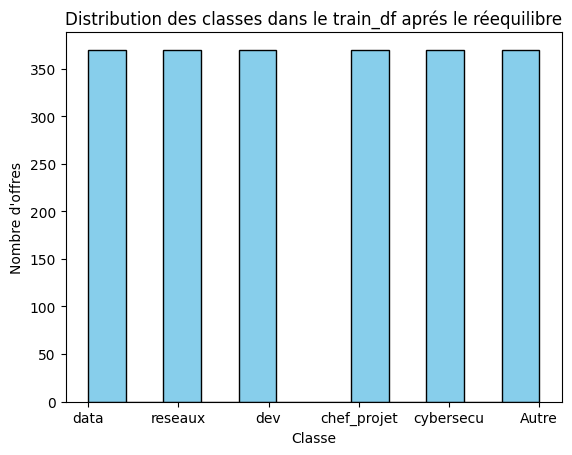

In [ ]:
plt.hist(train_df['label'], bins=12, color='skyblue', edgecolor='black')
plt.title('Distribution des classes dans le train_df aprés le réequilibre')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'offres')
plt.xticks([0, 1 , 2 , 3 , 4 , 5], labels= ["data" , "reseaux" , "dev" , "chef_projet" , "cybersecu" , "Autre"])  # Définir les étiquettes de l'axe x
plt.show()

# Lancement du modéle

In [ ]:
descriptions = train_df["preprocessed_description"].values
labels = train_df["label"].values

## Tokenization

In [ ]:
modelname = 'flaubert/flaubert_base_uncased'
tokenizer = FlaubertTokenizer.from_pretrained(modelname)
model = FlaubertForSequenceClassification.from_pretrained(modelname , num_labels = len(train_df["label"].value_counts()) , output_attentions = False , output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/917k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/550M [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_uncased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
token_ids = []
attention_masks = []
for dsc in descriptions:
    encoding_dict = tokenizer.encode_plus(dsc , add_special_tokens=True , max_length=256 ,truncation=True, padding='max_length' , return_attention_mask=True , return_tensors="pt")
    token_ids.append(encoding_dict["input_ids"])
    attention_masks.append(encoding_dict["attention_mask"])

In [ ]:
token_ids = torch.cat(token_ids , dim=0)
attention_masks = torch.cat(attention_masks , dim=0)
labels = torch.tensor(labels)

## Diviser les données de Train en Train/Dev

In [ ]:
val_ratio = 0.2
batch_size = 16

train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size=val_ratio, shuffle=True, stratify=labels, random_state=random_state)

train_set = TensorDataset(token_ids[train_ind], attention_masks[train_ind], labels[train_ind])
val_set = TensorDataset(token_ids[val_ind], attention_masks[val_ind], labels[val_ind])

train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=batch_size)
val_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

## Training

### Validation metrics

In [ ]:
def f1_score_function(y_hat, y):
    preds_flat = np.argmax(y_hat, axis=1).flatten()
    labels_flat = y.flatten()
    return f1_score(labels_flat, preds_flat, average="weighted")

In [ ]:
def accuracy_per_class(y_hat, y):
    predictions_flat = np.argmax(y_hat, axis=1).flatten()
    labels_flat = y.flatten()

    for label in np.unique(labels_flat):
        y_predictions = predictions_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class: {label}")
        print(f"Accuracy: {len(y_predictions[y_predictions==label])}/{len(y_true)}\n")

### Train configuration

In [ ]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu


### Phase d'entrainement

In [ ]:
def evaluate(val_dataloader):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in val_dataloader:

        batch = tuple(b.to(device) for b in batch)

        inputs = {"input_ids":      batch[0],
                  "attention_mask": batch[1],
                  "labels":         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs["labels"].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(val_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc="Epoch {:1d}".format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {"input_ids":      batch[0],
                  "attention_mask": batch[1],
                  "labels":         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"training_loss": "{:.3f}".format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f"/content/finetuned_BERT_epoch_{epoch}.model")

    tqdm.write(f"\nEpoch {epoch}")

    loss_train_avg = loss_train_total/len(train_dataloader)
    tqdm.write(f"Training loss: {loss_train_avg}")


val_loss, predictions, true_vals = evaluate(val_dataloader)
val_f1 = f1_score_function(predictions, true_vals)
tqdm.write(f"Validation loss: {val_loss}")
tqdm.write(f"F1 Score (Weighted): {val_f1}")

test_text = test_df["preprocessed_description"].values
test_labels = test_df["label"].values

test_token_ids = []
test_attention_masks = []
for test_description in test_text:
  test_encoding_dict = tokenizer.encode_plus(dsc , add_special_tokens=True , max_length=256 ,truncation=True, padding='max_length' , return_attention_mask=True , return_tensors="pt")
  test_token_ids.append(test_encoding_dict["input_ids"])
  test_attention_masks.append(test_encoding_dict["attention_mask"])

test_token_ids = torch.cat(test_token_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

test_set = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_set, sampler=RandomSampler(test_set), batch_size=batch_size)

_, test_predictions, test_true_vals = evaluate(test_dataloader)

test_f1_weighted = f1_score_function(test_predictions, test_true_vals)
print(f"F1 Score (Weighted): {test_f1_weighted}")

accuracy_per_class(test_predictions, test_true_vals)


 20%|██        | 1/5 [1:21:53<5:27:35, 4913.94s/it]


Epoch 1
Training loss: 1.8430393816114545



 40%|████      | 2/5 [2:43:27<4:05:05, 4901.78s/it]


Epoch 2
Training loss: 1.694595372354662



 60%|██████    | 3/5 [4:04:31<2:42:48, 4884.48s/it]


Epoch 3
Training loss: 1.184628550533776



 80%|████████  | 4/5 [5:25:56<1:21:24, 4884.76s/it]


Epoch 4
Training loss: 1.0034150840999845



100%|██████████| 5/5 [6:46:51<00:00, 4882.39s/it]



Epoch 5
Training loss: 0.9299650452695452
Validation loss: 0.9647982812353543
F1 Score (Weighted): 0.6596287978033252
F1 Score (Weighted): 0.018856145125575013
Class: 0
Accuracy: 0/289

Class: 1
Accuracy: 0/336

Class: 2
Accuracy: 0/572

Class: 3
Accuracy: 164/164

Class: 4
Accuracy: 0/82

Class: 5
Accuracy: 0/166



In [ ]:
    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_f1 = f1_score_function(predictions, true_vals)
    tqdm.write(f"Validation loss: {val_loss}")
    tqdm.write(f"F1 Score (Weighted): {val_f1}")

Validation loss: 0.9647982812353543
F1 Score (Weighted): 0.6596287978033252


## La prédiction

In [ ]:
test_text = test_df["preprocessed_description"].values
test_labels = test_df["label"].values

In [ ]:
test_token_ids = []
test_attention_masks = []
for test_description in test_text:
  test_encoding_dict = tokenizer.encode_plus(dsc , add_special_tokens=True , max_length=256 ,truncation=True, padding='max_length' , return_attention_mask=True , return_tensors="pt")
  test_token_ids.append(test_encoding_dict["input_ids"])
  test_attention_masks.append(test_encoding_dict["attention_mask"])

In [ ]:
test_token_ids = torch.cat(test_token_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

In [ ]:
test_set = TensorDataset(test_token_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_set, sampler=RandomSampler(test_set), batch_size=batch_size)

In [ ]:
_, test_predictions, test_true_vals = evaluate(test_dataloader)

In [ ]:
test_f1_weighted = f1_score_function(test_predictions, test_true_vals)
print(f"F1 Score (Weighted): {test_f1_weighted}")

F1 Score (Weighted): 0.018856145125575013


In [ ]:
accuracy_per_class(test_predictions, test_true_vals)

Class: 0
Accuracy: 0/289

Class: 1
Accuracy: 0/336

Class: 2
Accuracy: 0/572

Class: 3
Accuracy: 164/164

Class: 4
Accuracy: 0/82

Class: 5
Accuracy: 0/166

